<a href="https://colab.research.google.com/github/puneet-08/projects/blob/main/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition using FaceNet

Face Recognition is a method to identify an individual from a photograph. 
FaceNet is one of the techniques proposed by Google Researchers in 2015 in the paper titled [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832).

FaceNet employs a deep Convolutional Network which outputs an embedding of 128 elements. This embedding vector contains all the information which helps in perfoming the task.

In [1]:
#Importing the required libraries

!pip install mtcnn
!pip install tensorflow-addons

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import mtcnn
import os
import zipfile
from mtcnn.mtcnn import MTCNN
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

     |████████████████████████████████| 2.3 MB 34.6 MB/s 
     |████████████████████████████████| 1.1 MB 30.3 MB/s 


**Model Architechture**



Images are sent to a deep convolutional neural network. This CNN containes inception modules in blocks to reduce the number of trainable parameters. The output of this neural network is a 128 dimensional embedding vector. 

The main difference between FaceNet and other techniques is that it learns the mapping from the images and creates embeddings rather than using any bottleneck layer for recognition or verification tasks.

The network is trained such that L2 distance of the similar faces is low and that of dis-simlar faces is large. In order to follow this strategy the model is trained via **triplet loss function**  that encourages vectors for the same identity to become more similar (smaller distance), whereas vectors for different identities are expected to become less similar (larger distance). 

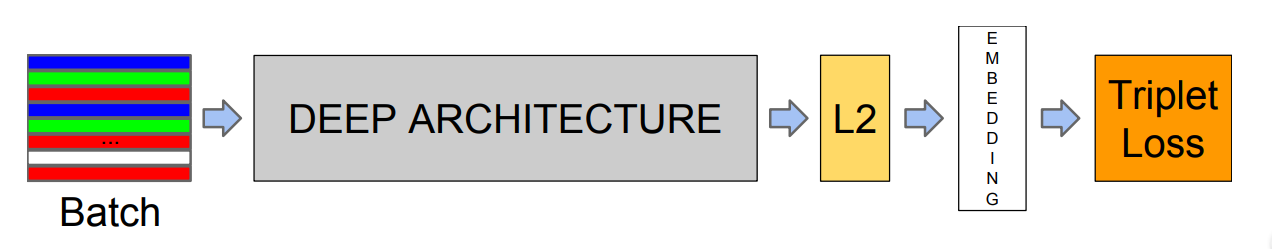

**Triplet Loss Function**

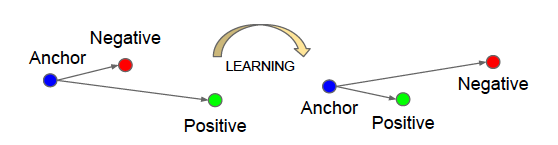

The intution behind triplet loss is that we want to learn embeddings such that -
the distance between anchor image (a random image of person A) and positive images (all the other images of person A in the training dataset) to be low AND the distance between anchor image and negative images (all the images of remaining people in the training dataset) to be high.
We need a triplet of images (anchor, positive and negative)in one training example, hence triplet loss.

Triplet loss is calculated by -

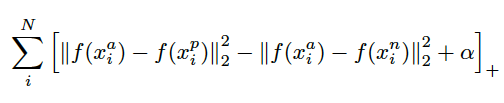

This formula says that the "*elucidian distance between anchor image and positive image*" to be **greater by some margin alpha** than "*the elucidian distance between anchor and negative image*".

If alpha is 0.5, then we want the difference between our anchor-positive image pair and anchor-negative image pair to be at least 0.5.

Therefore choosing the correct Anchor, Positive and Negative triplets becomes extremely important. If we choose these randomly, the model will not be robust. The best strategy is to find Anchor and Positive pairs such that L2 distance is largest, and Anchor and Negative pairs such that L2 distance is smallest; which is completly opposite of optimization we are aiming for in the triplet loss. This will ensure that our model is able to diffrentiate between similar looking people like twins.

For this notebook we are going to download a pretrained model provided by [Hiroki Taniai](https://github.com/nyoki-mtl) trained on [MS-Celeb-1M dataset](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/).

In [2]:
#Loading the model and pre-trained weights

model = load_model('/content/facenet_keras.h5')
model.load_weights('/content/facenet_keras_weights.h5')
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [ ]:
# model.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
#               loss = tfa.losses.TripletSemiHardLoss())

**Dataset**

The [5 Celebrity Faces Dataset](https://github.com/nyoki-mtl/keras-facenet) is a small dataset that contains photographs of celebrities.

It includes photos of: Ben Affleck, Elton John, Jerry Seinfeld, Madonna, and Mindy Kaling.

The dataset can be downloaded from kaggle.

Loading training and validation data-

In [6]:
zipfile.ZipFile('/content/archive.zip', 'r').extractall()

In [7]:
train_ben = os.path.join("/content/train/ben_afflek")
train_elton = os.path.join("/content/train/elton_john")
train_jerry = os.path.join("/content/train/jerry_seinfeld")
train_madonna = os.path.join("/content/train/madonna")
train_mindy = os.path.join("/content/train/mindy_kaling")

val_ben = os.path.join("/content/val/ben_afflek")
val_elton = os.path.join("/content/val/elton_john")
val_jerry = os.path.join("/content/val/jerry_seinfeld")
val_madonna = os.path.join("/content/val/madonna")
val_mindy = os.path.join("/content/val/mindy_kaling")

print('number of training ben examples:', len(os.listdir(train_ben)))
print('number of training elton examples:', len(os.listdir(train_elton)))
print('number of training jerry examples:', len(os.listdir(train_jerry)))
print('number of training madonna examples:', len(os.listdir(train_madonna)))
print('number of training mindy examples:', len(os.listdir(train_mindy)))


print('number of val ben examples:', len(os.listdir(val_ben)))
print('number of val elton examples:', len(os.listdir(val_elton)))
print('number of val jerry examples:', len(os.listdir(val_jerry)))
print('number of val madonna examples:', len(os.listdir(val_madonna)))
print('number of val mindy examples:', len(os.listdir(val_mindy)))

number of training ben examples: 14
number of training elton examples: 17
number of training jerry examples: 21
number of training madonna examples: 19
number of training mindy examples: 22
number of val ben examples: 5
number of val elton examples: 5
number of val jerry examples: 5
number of val madonna examples: 5
number of val mindy examples: 5


In [8]:
index = 2

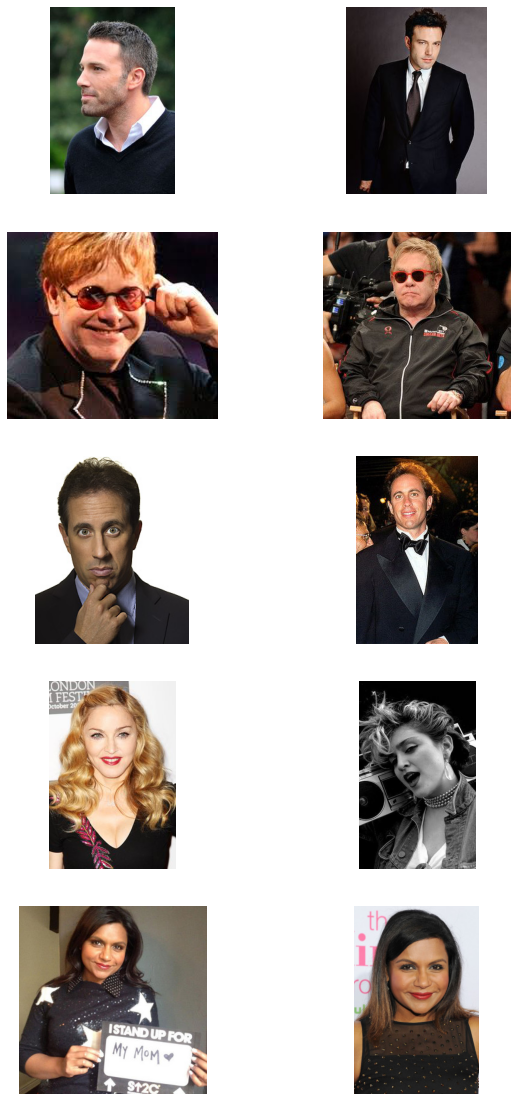

In [9]:
#Plotting a couple of the training images for each celeb

files_train_ben = [os.path.join(train_ben, image) for image in os.listdir(train_ben)]
files_train_elton = [os.path.join(train_elton, image) for image in os.listdir(train_elton)]
files_train_jerry = [os.path.join(train_jerry, image) for image in os.listdir(train_jerry)]
files_train_madonna = [os.path.join(train_madonna, image) for image in os.listdir(train_madonna)]
files_train_mindy = [os.path.join(train_mindy, image) for image in os.listdir(train_mindy)]

files_val_ben = [os.path.join(val_ben, image) for image in os.listdir(val_ben)]
files_val_elton = [os.path.join(val_elton, image) for image in os.listdir(val_elton)]
files_val_jerry = [os.path.join(val_jerry, image) for image in os.listdir(val_jerry)]
files_val_madonna = [os.path.join(val_madonna, image) for image in os.listdir(val_madonna)]
files_val_mindy = [os.path.join(val_mindy, image) for image in os.listdir(val_mindy)]

index += 2
                                                              
images = files_train_ben[index-2:index] + files_train_elton[index-2:index] + \
         files_train_jerry[index-2:index] + files_train_madonna[index-2:index] + \
         files_train_mindy[index-2:index]

plt.figure(figsize = (10,20))

for i,image in enumerate(images):
  plt.subplot(5,2,i+1)
  plt.axis('Off')
  img = mpimg.imread(image)
  plt.imshow(img)
plt.show()


In [10]:
# Function to normalize the image array
def normalize(img):
  mean, std = img.mean(), img.std()
  return (img - mean)/std

Next we need to extract faces of the individuals from the images. The process of extracting face is called as Face detection. In this notebook, we will also use the **Multi-Task Cascaded Convolutional Neural Network, or MTCNN**, for face detection, i.e. finding and extracting faces from photos.

In [11]:
# Function to extract faces 
def extract_face(image, required_shape = (160, 160)):

  img_BGR = cv2.imread(image) #reads image in BGR format. needs to be converted
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

  detector = MTCNN()
  x = detector.detect_faces(img_RGB)
  x1, y1, width, height = x[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height

  face = img_RGB[y1:y2 , x1:x2]

  face = face.astype('float')
  face = normalize(face)
  face = cv2.resize(face, required_shape)
  face = np.expand_dims(face, axis = 0)

  return face

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


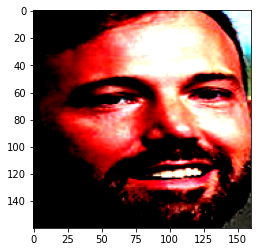

In [12]:
#Testing if the function works
plt.imshow(extract_face(files_train_ben[5])[0])

In [13]:
# Creating embeddings for all of the training data
training = [files_train_ben, files_train_elton, files_train_jerry, files_train_madonna, files_train_mindy]
encoding= []
for celebs in training:
  encoding_inner = []
  for img in celebs:
    face = extract_face(img)
    encoding_inner.append(model.predict(face)[0])
  encoding.append(encoding_inner)

In [14]:
# Taking mean of the all of the embeddings so that we have a single unique embedding per person. 
ben = np.mean(encoding[0], axis =0)
elton =np.mean(encoding[1], axis =0)
jerry = np.mean(encoding[2], axis =0)
madonna = np.mean(encoding[3], axis =0)
mindy = np.mean(encoding[4], axis = 0)
final_encodings = [ben, elton, jerry, madonna, mindy]

In [15]:
final_encodings

[array([ 1.30548375e-02,  7.67006218e-01, -7.66673505e-01, -9.59415615e-01,
         2.42203847e-01, -5.71977496e-01,  8.90620351e-01, -3.60002607e-01,
         2.50887215e-01, -6.52322590e-01,  8.36837590e-01, -5.72335303e-01,
         1.74204513e-01, -6.48003757e-01,  8.13071311e-01, -1.05821826e-01,
        -1.68603134e+00, -7.48863071e-02, -4.47120726e-01, -3.03106140e-02,
         1.37355101e+00,  1.37372836e-01,  2.24569105e-02, -1.03580594e-01,
         7.19784647e-02, -4.12092209e-01,  5.22036195e-01, -1.09681773e+00,
        -6.85520232e-01,  6.11588120e-01, -2.98111886e-01,  8.09485018e-01,
         1.30415404e+00,  5.54712057e-01, -6.68638170e-01,  8.37067068e-01,
        -1.59404111e+00, -7.16970623e-01, -1.41936243e+00, -2.03858405e-01,
         1.01352704e+00, -1.99664012e-01, -3.24225247e-01,  9.13496017e-02,
        -6.30614832e-02, -6.21477425e-01,  8.62486064e-01,  8.01408067e-02,
        -1.57618953e-03,  1.59724355e-01, -8.36712837e-01, -5.13884485e-01,
         2.2

In [16]:
model.predict(extract_face(files_train_ben[5])).shape

(1, 128)

**Predicting Identity**

We are going to employ a simple crude technique for prediction -

*   We are going to calculate embedding of the input image.
*   Then we are going to calculate the L2 distance of the input image from each of the five distinct embeddings of the celebs.
*   If the distance is greater than a certain threshold we are going to predict - 'person is not in the dataset'.
*   If the distance is less than a certain threshold, we predict the identity for which L2 distance is lowest.

**Now the question is how do we calculate threshold?**

For this, we are going to start with a random guess. Test this method for all of the training dataset. Then select the threshold value more than the highest min distance we obtain during the training.



In [20]:
# Writing a funciton to find the identity given an image
def who_is_it(image_path, final_encodings, model):
  identity = ['ben','elton', 'jerry','madonna','mindy']
  encoding = model.predict(extract_face(image_path))[0]
  max_dis = 10000000
  threshold = 12
  dist = []
  for i in final_encodings:
    dist_ = np.linalg.norm(i-encoding)
    dist.append(dist_)

  min_dist = min(dist) 
  if min_dist > threshold:
    print('Person is not in the database. Min Dist :', min_dist)
    plt.axis('Off')
    plt.imshow(extract_face(image_path)[0])
    plt.show()
  else:
    mask = np.argmin(dist)
    print('Identity of the person is  :', identity[mask], "   Min dist :", min_dist)
    plt.axis('Off')
    plt.imshow(extract_face(image_path)[0])
    plt.show()

In [18]:
train_images = files_train_ben + files_train_elton + files_train_jerry + files_train_madonna + files_train_mindy
for image in train_images:
  who_is_it(image, final_encodings, model)

Identity of the person is  : ben    Min dist : 6.4692984
Identity of the person is  : ben    Min dist : 8.200593
Identity of the person is  : ben    Min dist : 8.116491
Identity of the person is  : ben    Min dist : 6.189007
Identity of the person is  : ben    Min dist : 6.8893805
Identity of the person is  : ben    Min dist : 5.859119
Identity of the person is  : ben    Min dist : 8.9823265
Identity of the person is  : ben    Min dist : 7.739059
Identity of the person is  : ben    Min dist : 7.0296135
Identity of the person is  : ben    Min dist : 5.956979
Identity of the person is  : ben    Min dist : 10.339933
Identity of the person is  : ben    Min dist : 5.5529165
Identity of the person is  : ben    Min dist : 6.652508
Identity of the person is  : ben    Min dist : 9.134869
Identity of the person is  : elton    Min dist : 8.273312
Identity of the person is  : elton    Min dist : 10.159762
Identity of the person is  : elton    Min dist : 9.177134
Identity of the person is  : elton 

The maximum min distance is 11.22 for an image of Mindy. We are going to use 12 as threshold in the 'who_is_it' function.

Identity of the person is  : ben    Min dist : 10.773741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


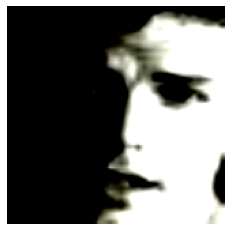

Identity of the person is  : ben    Min dist : 5.4610825


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


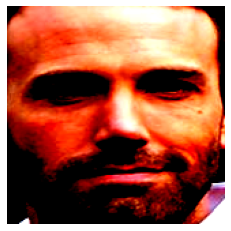

Identity of the person is  : ben    Min dist : 6.571701


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


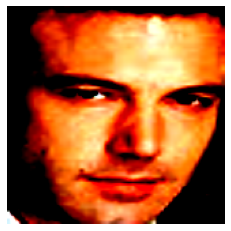

Identity of the person is  : ben    Min dist : 6.227771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


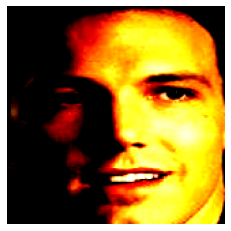

Identity of the person is  : ben    Min dist : 5.972844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


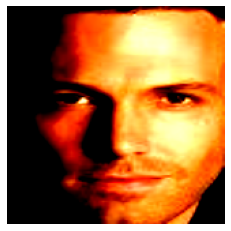

Identity of the person is  : elton    Min dist : 8.203365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


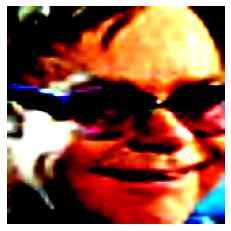

Identity of the person is  : elton    Min dist : 6.1067348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


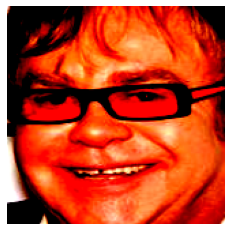

Identity of the person is  : elton    Min dist : 7.3328414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


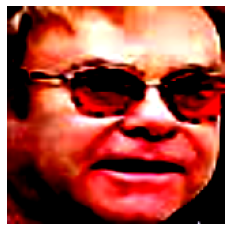

Identity of the person is  : elton    Min dist : 7.264567


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


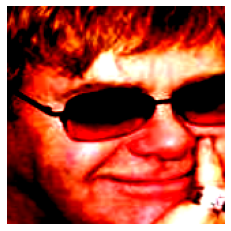

Identity of the person is  : elton    Min dist : 7.404986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


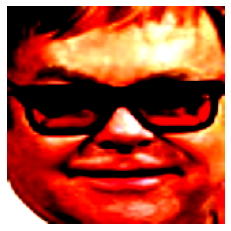

Identity of the person is  : jerry    Min dist : 3.7178624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


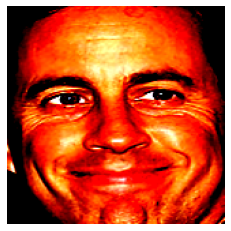

Identity of the person is  : jerry    Min dist : 5.3585997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


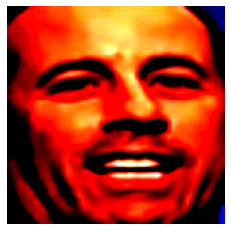

Identity of the person is  : jerry    Min dist : 5.8533874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


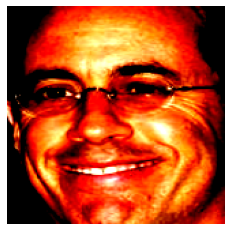

Identity of the person is  : jerry    Min dist : 4.537897


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


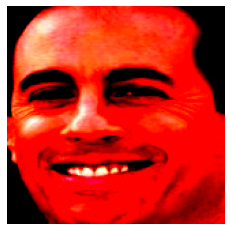

Identity of the person is  : jerry    Min dist : 8.147902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


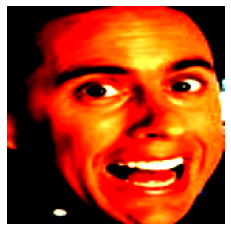

Identity of the person is  : madonna    Min dist : 8.661352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


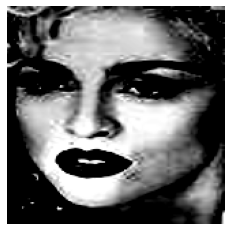

Identity of the person is  : madonna    Min dist : 9.02779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


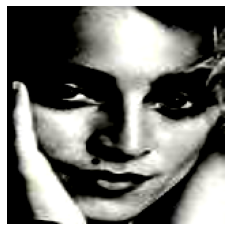

Identity of the person is  : madonna    Min dist : 6.733583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


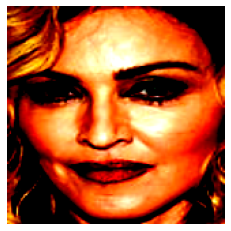

Identity of the person is  : madonna    Min dist : 8.482961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


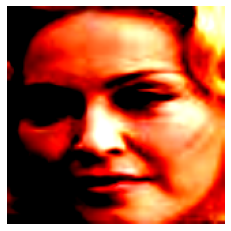

Identity of the person is  : madonna    Min dist : 9.207982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


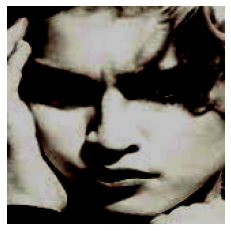

Identity of the person is  : mindy    Min dist : 3.9693906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


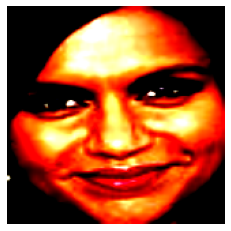

Identity of the person is  : mindy    Min dist : 7.925879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


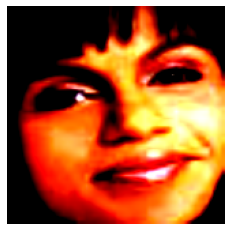

Identity of the person is  : mindy    Min dist : 6.116399


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


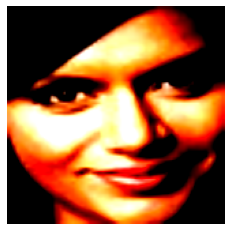

Identity of the person is  : mindy    Min dist : 4.1564794


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


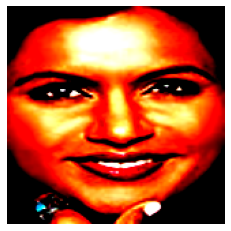

Identity of the person is  : mindy    Min dist : 5.806675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


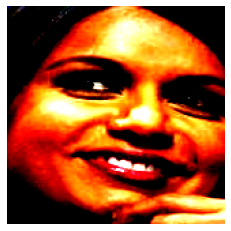

In [21]:
#Now predicting on the val dataset

val_images = files_val_ben + files_val_elton + files_val_jerry + files_val_madonna + files_val_mindy

for image in val_images:
  who_is_it(image, final_encodings, model)


In this notebook we have used a crude way to calculate the threshold and hence predict the identity. However, it does a pretty good job on our validation dataset. We can also use machine learning algorithms like SVM, feed in the learned embeddings as inputs, and tackle it like a multi-class classificaton problem.

**References**

*   https://arxiv.org/abs/1503.03832
*   https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
*   https://github.com/nyoki-mtl/keras-facenet


